In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from bnr_ml.nnet import layers
from bnr_ml.objectdetect import yolo
from bnr_ml.nnet.updates import momentum
import theano
from theano import tensor as T
from collections import OrderedDict
from tqdm import tqdm
import time

import lasagne
import lasagne.layers as layers

import pickle as pk

import pdb

In [4]:
def gen_num_objs(max_obj):
    return int(1 + max_obj * np.random.rand())

In [5]:
def gen_classes(num_obj, num_class):
    return np.random.randint(num_class, size=(num_obj,))

In [6]:
def gen_circle(shape):
#     pdb.set_trace()
    row, col = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    row, col = row.astype(np.float64), col.astype(np.float64)
    row = (row - row.shape[1] / 2) / (row.shape[1] / 2)
    col = (col - col.shape[0] / 2) / (col.shape[0] / 2)
    
    
    im = np.zeros(shape + (1,))
    for i in range(im.shape[2]):
        in_ellipse = (row**2 + col**2) < 1
#         im[:,:,i][in_ellipse] = (np.random.gamma(.7) + np.random.gamma(.4) * np.random.randn(*shape))[in_ellipse]
        im[:,:,i][in_ellipse] = np.ones(shape)[in_ellipse]
    im[im < 0] = 0.
    im[im >= 1] = 1.
    return im

In [7]:
def gen_rect(shape):
    im = np.zeros(shape + (3,))
    for i in range(3):
        im[:,:,i] = (np.random.gamma(.7) + np.random.gamma(.4) * np.random.randn(*shape))
    im[im < 0] = 0.
    im[im > 1] = 1.
    return im

In [8]:
def gen_triangle(shape):
    row, col = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    row, col = row.astype(np.float64), col.astype(np.float64)
    row = row / row.shape[1]
    col = col / col.shape[0]
    
    
    im = np.zeros(shape + (1,))
    if np.random.rand() < .5:
        in_triangle = row + col < 1
    else:
        in_triangle = row + col > 1
    for i in range(im.shape[2]):
        im[:,:,i][in_triangle] = np.ones(shape)[in_triangle]
#         im[:,:,i][in_triangle] = (np.random.gamma(.7) + np.random.gamma(.4) * np.random.randn(*shape))[in_triangle]
    im[im < 0] = 0.
    im[im >= 1] = 1.
    return im

In [9]:
def gen_pos_shape(min_shape, im_shape):
    shape = (
        int(min_shape[0] + (im_shape[0] - min_shape[0]) * np.random.rand()),
        int(min_shape[1] + (im_shape[1] - min_shape[1]) * np.random.rand())
    )
    pos = (
        int((im_shape[0] - shape[0]) * np.random.rand()),
        int((im_shape[1] - shape[1]) * np.random.rand())
    )
    return shape, pos

In [10]:
def gen_scene(max_obj, num_class, min_shape, im_shape):
    num_obj = gen_num_objs(max_obj)
    classes = gen_classes(num_obj, num_class)
    im = np.random.gamma(.4) * np.random.randn(*(im_shape + (1,)))
    im[im < 0] = 0.
    im[im > 1] = 1.
    y = np.zeros((4 + num_class,))
    
    for cls in classes:
        shape, pos = gen_pos_shape(min_shape, im_shape)
        if cls == 0:
            shp = gen_circle(shape)
        elif cls == 1:
            shp = gen_triangle(shape)
        elif cls == 2:
            shp = gen_triangle(shape)
        else:
            pass
        im[pos[0]:pos[0]+shape[0],pos[1]:pos[1]+shape[1],:] += shp
        y[:4] = pos + shape
        y = y.astype(np.float64)
        y[[0,2]] /= im_shape[0]
        y[[1,3]] /= im_shape[1]
        y[-num_class + cls] += 1.
    return im / np.max(im), y

In [11]:
def gen_dataset(size, shape, max_obj=1):
    X, y = np.zeros((size,1) + shape), np.zeros((size,4+2))
    for i in range(size):
        dat = gen_scene(max_obj, 2, (20, 20), shape)
        X[i], y[i] = dat[0].swapaxes(2,1).swapaxes(1,0), dat[1]
    return X.astype(theano.config.floatX), y.astype(theano.config.floatX)

In [12]:
X,y = gen_dataset(100
               

00, (100,100))

In [ ]:
N = np.int_(X.shape[0] * np.random.rand())
plt.imshow(X[N,0], 'gray')
plt.show()

print y[N,:4]

In [13]:
input = T.tensor4('input')
# input = theano.shared(X[:10], name='dat', borrow=True)

In [14]:
l1 = layers.InputLayer((None,1,100,100), input_var=input)
l2 = layers.Conv2DLayer(
    l1,
    8,
    (3,3)
)
l3 = layers.Conv2DLayer(
    l2,
    8,
    (3,3)
)
l4 = layers.Pool2DLayer(
    l3,
    (3,3)
)
l5 = layers.Conv2DLayer(
    l4,
    16,
    (3,3)
)
l6 = layers.Conv2DLayer(
    l5,
    16,
    (3,3)
)
l7 = layers.Pool2DLayer(
    l6,
    (3,3)
)

le1 = layers.Conv2DLayer(
    l7,
    16,
    (3,3)
)
le2 = layers.Conv2DLayer(
    le1,
    16,
    (3,3)
)
le3 = layers.Pool2DLayer(
    le2,
    (2,2)
)

l8 = layers.DenseLayer(
    layers.dropout(le3, p=.2),
    100
)
l9 = layers.DenseLayer(
    layers.dropout(l8, p=.2),
    100,
)
l10 = layers.DenseLayer(
    layers.dropout(l9, p=.2),
    2,
    nonlinearity=lasagne.nonlinearities.softmax
)

In [15]:
with open('../weights/weights.pkl', 'rb') as f:
    weights = pk.load(f)
    weights = [w.astype(theano.config.floatX) for w in weights]

In [16]:
layers.set_all_param_values(l10, weights)

In [17]:
olayer = layers.DenseLayer(
    layers.dropout(l8, p=.2),
    2 * 2 * (10 + 2)
)

In [ ]:
# with open('../weights/yolo_weights.pkl', 'wb') as f:
#     pk.dump(layers.get_all_param_values(olayer), f)
with open('../weights/yolo_weights.pkl', 'rb') as f:
    weights = pk.load(f)
    weights = [w.astype(theano.config.floatX) for w in weights]
layers.set_all_param_values(olayer, weights)

In [18]:
net = {}
net['input'] = l1
net['l2'] = l2
net['l3'] = l3
net['l4'] = l4
net['l5'] = l5
net['l6'] = l6
net['l7'] = l7
net['le1'] = le1
net['le2'] = le2
net['le3'] = le3
net['l8'] = l8
net['output'] = olayer

In [19]:
reload(layers)
reload(yolo)

<module 'bnr_ml.objectdetect.yolo' from '/usr/local/python/bnr_ml/objectdetect/yolo.pyc'>

In [20]:
yl = yolo.YoloObjectDetector(net, (None,1,100,100), 2, (2,2), 2)

/Library/Python/2.7/site-packages/lasagne/layers/conv.py:489: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  border_mode=border_mode)


In [ ]:
# target = theano.shared(y[:10], name='gt', borrow=True)
# output = T.as_tensor(output_fn(X[:1000]))
# target = T.as_tensor(y[:1000])

output = T.tensor4('output')
target = T.matrix('target')

In [69]:
train_loss, test_loss = yl.train(
    X[:5000],
    y[:5000],
    lr=1e-3,
    momentum=0.5,
    train_test_split=0.9,
    epochs=40,
    batch_size=4,
    lmbda_coord=5.,
    lmbda_noobj=.5,
    target=None
)

Getting cost...
Creating cost variable took 0.3693 seconds
Compiling...


  0%|          | 0/40 [00:00<?, ?it/s]

Compiling functions took 21.1669 seconds
Beginning training...


  2%|▎         | 1/40 [00:02<01:52,  2.88s/it]

Epoch 0
------
Train Loss: 8.7450, Test Loss: 217.1312


  5%|▌         | 2/40 [00:05<01:49,  2.87s/it]

Epoch 1
------
Train Loss: 8.6952, Test Loss: 217.9138


  8%|▊         | 3/40 [00:08<01:46,  2.87s/it]

Epoch 2
------
Train Loss: 8.6516, Test Loss: 215.5129


 10%|█         | 4/40 [00:11<01:42,  2.86s/it]

Epoch 3
------
Train Loss: 8.6664, Test Loss: 215.3743


 12%|█▎        | 5/40 [00:14<01:39,  2.85s/it]

Epoch 4
------
Train Loss: 8.6729, Test Loss: 214.5569


 15%|█▌        | 6/40 [00:17<01:36,  2.85s/it]

Epoch 5
------
Train Loss: 8.6607, Test Loss: 213.8068


 18%|█▊        | 7/40 [00:19<01:34,  2.85s/it]

Epoch 6
------
Train Loss: 8.6658, Test Loss: 213.8857


 20%|██        | 8/40 [00:22<01:31,  2.85s/it]

Epoch 7
------
Train Loss: 8.6043, Test Loss: 213.9476


 22%|██▎       | 9/40 [00:25<01:28,  2.85s/it]

Epoch 8
------
Train Loss: 8.5916, Test Loss: 217.4894


 25%|██▌       | 10/40 [00:28<01:25,  2.85s/it]

Epoch 9
------
Train Loss: 8.5908, Test Loss: 214.7535


 28%|██▊       | 11/40 [00:31<01:22,  2.85s/it]

Epoch 10
------
Train Loss: 8.5926, Test Loss: 213.4326


 30%|███       | 12/40 [00:34<01:19,  2.85s/it]

Epoch 11
------
Train Loss: 8.6085, Test Loss: 214.8605


 32%|███▎      | 13/40 [00:37<01:16,  2.84s/it]

Epoch 12
------
Train Loss: 8.5598, Test Loss: 213.7789


 35%|███▌      | 14/40 [00:39<01:13,  2.84s/it]

Epoch 13
------
Train Loss: 8.5467, Test Loss: 214.1262


 38%|███▊      | 15/40 [00:42<01:11,  2.84s/it]

Epoch 14
------
Train Loss: 8.5810, Test Loss: 213.1553


 40%|████      | 16/40 [00:45<01:08,  2.84s/it]

Epoch 15
------
Train Loss: 8.5717, Test Loss: 212.7832


 42%|████▎     | 17/40 [00:48<01:05,  2.84s/it]

Epoch 16
------
Train Loss: 8.5415, Test Loss: 211.0291


 45%|████▌     | 18/40 [00:51<01:02,  2.85s/it]

Epoch 17
------
Train Loss: 8.5354, Test Loss: 211.5021


 48%|████▊     | 19/40 [00:54<01:00,  2.87s/it]

Epoch 18
------
Train Loss: 8.5176, Test Loss: 213.3315


 50%|█████     | 20/40 [00:57<00:57,  2.87s/it]

Epoch 19
------
Train Loss: 8.5344, Test Loss: 212.6120


 52%|█████▎    | 21/40 [01:00<00:54,  2.89s/it]

Epoch 20
------
Train Loss: 8.5303, Test Loss: 214.0455


 55%|█████▌    | 22/40 [01:02<00:51,  2.89s/it]

Epoch 21
------
Train Loss: 8.4777, Test Loss: 211.6178


 57%|█████▊    | 23/40 [01:05<00:48,  2.88s/it]

Epoch 22
------
Train Loss: 8.5041, Test Loss: 213.2301


 60%|██████    | 24/40 [01:08<00:46,  2.89s/it]

Epoch 23
------
Train Loss: 8.5297, Test Loss: 211.4097


 62%|██████▎   | 25/40 [01:11<00:43,  2.89s/it]

Epoch 24
------
Train Loss: 8.4706, Test Loss: 211.4791


 65%|██████▌   | 26/40 [01:14<00:40,  2.89s/it]

Epoch 25
------
Train Loss: 8.4686, Test Loss: 210.7274


 68%|██████▊   | 27/40 [01:17<00:37,  2.90s/it]

Epoch 26
------
Train Loss: 8.4915, Test Loss: 210.8021


 70%|███████   | 28/40 [01:20<00:34,  2.88s/it]

Epoch 27
------
Train Loss: 8.4648, Test Loss: 210.6524


 72%|███████▎  | 29/40 [01:23<00:31,  2.87s/it]

Epoch 28
------
Train Loss: 8.4597, Test Loss: 210.9250


 75%|███████▌  | 30/40 [01:25<00:28,  2.86s/it]

Epoch 29
------
Train Loss: 8.4644, Test Loss: 210.0880


 78%|███████▊  | 31/40 [01:28<00:25,  2.86s/it]

Epoch 30
------
Train Loss: 8.4723, Test Loss: 211.7872


 80%|████████  | 32/40 [01:31<00:22,  2.85s/it]

Epoch 31
------
Train Loss: 8.4530, Test Loss: 211.8255


 82%|████████▎ | 33/40 [01:34<00:19,  2.85s/it]

Epoch 32
------
Train Loss: 8.4451, Test Loss: 211.1494


 85%|████████▌ | 34/40 [01:37<00:17,  2.85s/it]

Epoch 33
------
Train Loss: 8.4831, Test Loss: 211.6768


 88%|████████▊ | 35/40 [01:40<00:14,  2.85s/it]

Epoch 34
------
Train Loss: 8.5022, Test Loss: 211.9837


 90%|█████████ | 36/40 [01:42<00:11,  2.85s/it]

Epoch 35
------
Train Loss: 8.4606, Test Loss: 210.1094


 92%|█████████▎| 37/40 [01:45<00:08,  2.84s/it]

Epoch 36
------
Train Loss: 8.4962, Test Loss: 210.8306


 95%|█████████▌| 38/40 [01:48<00:05,  2.85s/it]

Epoch 37
------
Train Loss: 8.4592, Test Loss: 212.4439


 98%|█████████▊| 39/40 [01:51<00:02,  2.85s/it]

Epoch 38
------
Train Loss: 8.4529, Test Loss: 210.9162


100%|██████████| 40/40 [01:54<00:00,  2.84s/it]

Epoch 39
------
Train Loss: 8.4673, Test Loss: 211.5117


Changed the regularization parameter to improve the classification accuracy.

In [72]:
testl, trainl = test_loss, train_loss
# testl, trainl = np.concatenate((testl, test_loss)), np.concatenate((trainl, train_loss))

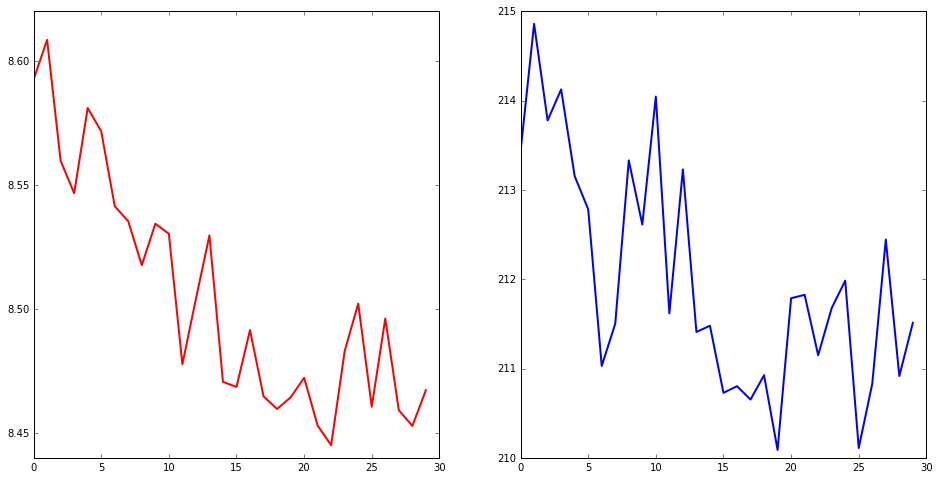

In [77]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(trainl[10:], 'r', linewidth=2.0)
plt.subplot(1,2,2)
plt.plot(testl[10:], 'b', linewidth=2.0)
plt.show()

In [78]:
pred_fn = theano.function([yl.input], yl.output)

In [84]:
# Xtest, ytest = gen_dataset(1000, (100,100), max_obj=1)
Xtest, ytest = X[:1000], y[:1000]

In [85]:
ti = time.time()
tmp = pred_fn(Xtest[:500])
tf = time.time()
print ((tf - ti) / tmp.shape[0])

0.000280379772186


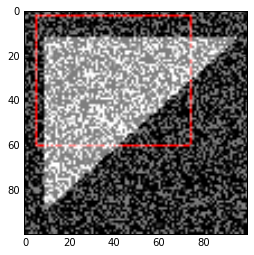

In [134]:
N = np.int_(tmp.shape[0] * np.random.rand())
im = Xtest[N,0]
probs = tmp[N]
idx = np.argmax(probs)
im = draw_coords(im, find_best_coords(probs, (100,100)))
plt.imshow(im)
plt.show()
# if idx == 0:
#     print('Circle with confidence: %.3f' % probs[idx])
# else:
#     print('Triangle with confidence: %.3f' % probs[idx])
# print iou

In [41]:
def find_best_coords(output, shape):
    idx = np.argmax(output[[4,9],:,:])
    coord = np.unravel_index(idx, (2,2,2))
    best = np.copy(output[coord[0] * 5:coord[0]*5 + 4, coord[1], coord[2]])
    best[0] += float(coord[1]) / 2
    best[1] += float(coord[2]) / 2
    return best #, output[-2:,coord[1],coord[2]], output[[4,9],:,:][coord[0],coord[1],coord[2]]

In [27]:
def find_best_coords_2(output, shape):
    best = np.zeros((4,4))
    confs = np.zeros((4,))
    cnt = 0
    for i in range(2):
        for j in range(2):
            pred = output[:,i,j]
            idx = np.argmax(pred[[4,9]])
            coord = pred[idx * 5:idx*5 + 4]
            conf = np.max(pred[-2:]) #* pred[idx*5 + 4]
#             conf = pred[idx*5 + 4]
            best[cnt] = coord
            confs[cnt] = conf
            cnt += 1
    return best, confs

In [ ]:
find_best_coords_2(tmp[N], (100,100))

In [29]:
def draw_coords(im, coord):
    coord[[0,2]] *= im.shape[0]
    coord[[1,3]] *= im.shape[1]
    coord = coord.astype(np.int32)
    if im.shape.__len__() < 3:
        im = np.copy(im)
        im = im.reshape(im.shape + (1,))
        im = np.concatenate((im,im,im), axis=2)
    def bound(num, lb, ub):
        return min(ub, max(num,lb))
    ri,rf = bound(coord[0], 0, im.shape[0]-1), bound(coord[0]+coord[2], 0, im.shape[0]-1)
    ci,cf = bound(coord[1], 0, im.shape[1]-1), bound(coord[1]+coord[3], 0, im.shape[1]-1)
    im[ri:rf, ci,0] = 1.0
    im[ri:rf, cf,0] = 1.0
    im[ri, ci:cf,0] = 1.0
    im[rf, ci:cf,0] = 1.0
    return im

In [ ]:
a = draw_coords(X[N,0], find_best_coords(tmp[N], (100,100))[0])

In [ ]:
a.shape

In [ ]:
plt.imshow(a)

In [ ]:
print find_best_coords(tmp[N], (100,100))

In [ ]:
np.argmax(tmp[0,[4,9],:,:])

In [ ]:
np.unravel_index(4, (2,2,2))

In [ ]:
tmp[0,[4,9],:,:][1,0,0]

In [ ]:
act_fn = theano.function([input], layers.get_output(le3))

In [ ]:
tmp = act_fn(X[:20])

In [ ]:
tmp.max()

In [ ]:
Xtest, ytest = gen_dataset(100, (100,100))

In [ ]:
preds = pred_fn(Xtest)

In [ ]:
N = np.int_(Xtest.shape[0] * np.random.rand())
fig = plt.figure(figsize=(7,7))
plt.imshow(Xtest[N,0], 'gray')
plt.show()

for i in range(2):
    for j in range(2):
        print preds[N,:,i,j]

In [ ]:
ytest[N]